<a href="https://colab.research.google.com/github/toastmaker/ccf/blob/master/notebooks/lc_delay_ml_Y_shape.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot  as plt
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Dropout, Input, Concatenate
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, DotProduct, WhiteKernel
from keras import metrics
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from google.colab import drive

In [ ]:
# load data
drive.mount('/content/drive')
copypath = '/content/drive/My Drive/data/lightcurve_array.npz'
npz=np.load(copypath)
xdata=npz['lc'][:,:-1] # to make the legth of the two concatenated light curves an even number
ydata=npz['delay']*1e3 # convert to human read units
xdata.shape

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


(9999, 9998)

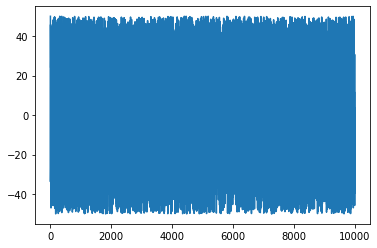

In [93]:
plt.plot(ydata)

In [ ]:
xdata = xdata/np.max(xdata,axis=1)[:,np.newaxis]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(xdata, ydata, test_size=0.30, random_state=0)
half = xdata.shape[1]//2
X_train1 = X_train[:,:half]
X_train2 = X_train[:,half:]
X_test1 = X_test[:,:half]
X_test2 = X_test[:,half:]

In [ ]:
X_train.shape, X_train1.shape, X_train2.shape, y_train.shape

((6999, 9998), (6999, 4999), (6999, 4999), (6999,))

In [ ]:
X_train1[0].shape

(4999,)

In [122]:
# Y shape network, two inputs layer 'dense' is common for both branches (same weights)
lc1 = Input(shape=(X_train1[0].shape))
lc2 = Input(shape=(X_train2[0].shape))

dense = Dense(units=128, input_shape=X_train1[0].shape,activation='sigmoid')
branch1 = dense(lc1)
branch1 = Dense(units=24, activation='sigmoid')(branch1)
branch2  = dense(lc2)
branch2 = Dense(units=24, activation='sigmoid')(branch2)
merge_layer = Concatenate()([branch1, branch2])
mixer_layer = Dense(units=16, activation='sigmoid')(merge_layer)
predictions = Dense(units=1)(mixer_layer)
model = Model(inputs=[lc1, lc2], outputs=predictions)

In [123]:
m=[metrics.mean_squared_error, metrics.mean_absolute_error]
model.compile(loss='mean_squared_error', optimizer='adamax', metrics=m)

In [124]:
model.summary()

Model: "functional_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_39 (InputLayer)           [(None, 4999)]       0                                            
__________________________________________________________________________________________________
input_40 (InputLayer)           [(None, 4999)]       0                                            
__________________________________________________________________________________________________
dense_50 (Dense)                (None, 128)          640000      input_39[0][0]                   
                                                                 input_40[0][0]                   
__________________________________________________________________________________________________
dense_51 (Dense)                (None, 24)           3096        dense_50[0][0]       

In [125]:
nepochs = 200
batch_size = 100
h = model.fit([X_train1, X_train2],y_train,epochs=nepochs,batch_size=batch_size, validation_data=([X_test1, X_test2],y_test), verbose=0)

In [126]:
def accuracy_plot(y_test, y_pred):
  plt.scatter(y_test,y_pred,color="r")
  plt.xlabel("True delay")
  plt.xlabel("ML delay")
  plt.plot([-0.06*1e3,0.06*1e3],[-0.06*1e3,0.06*1e3],':')
  plt.xlim([-0.06*1e3,0.06*1e3])
  plt.ylim([-0.06*1e3,0.06*1e3])

In [127]:
def howGoodAmI(y_test, y_pred):
  diff = y_test - y_pred.ravel()
  hist = plt.hist(diff)
  bincentres = (hist[1][:-1]+hist[1][1:])/2.
  weights = hist[0]
  mu = np.average(bincentres,weights=weights)
  sigma = np.average((bincentres-mu)**2, weights=weights)
  return mu, sigma

In [128]:
def error_evolution(h):
  # summarize history for loss
  plt.plot(h.history['mean_squared_error'], label='train')
  plt.plot(h.history['val_mean_squared_error'], label='test')
  plt.title('model mse')
  plt.ylabel('mse')
  plt.xlabel('epoch')
  plt.legend()

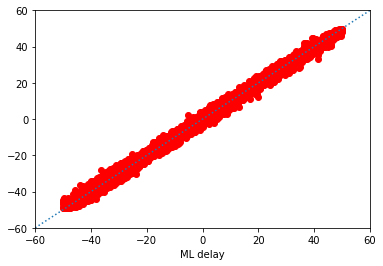

In [129]:
y_pred = model.predict([X_test1, X_test2])
accuracy_plot(y_test, y_pred)

(0.06904561774805189, 4.420608955368543)

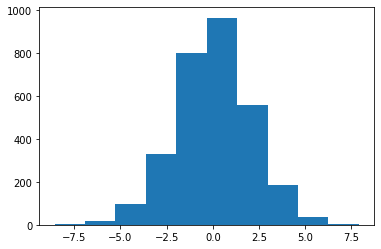

In [130]:
howGoodAmI(y_test, y_pred)

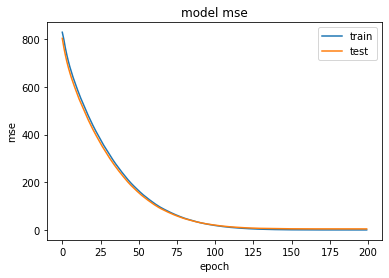

In [131]:
error_evolution(h)